# CEX vs. DEX lending rates difference analysis

This is an example of analysing differences between CEX and DEX lending rates for the same or similar asset.
The notebook can be used to examine how efficient the markets are and how similar is the price action.

- In this notebook, we compare lending Arbitrum `WETH` and `USDC` on Uniswap v3 to lending the same assets on Binance

- We compare one hour candles

## Summary

- Lending rate differences stay volatile over time, unlike price action differences which have gotten tighter over time.

### Higher lending rates on DEXes

Lending rates for DEXs are consistently higher than lending rates for CEXs. This is to be expected for a few reasons:

1. Risk Premium: DEXs operate on decentralized networks and often lack the regulatory oversight or the established trust that CEXs might have. Lenders typically demand higher returns as compensation for the perceived increase in risk.

2. Operational Costs and Efficiency: CEXs often have more efficient capital utilization and lower operational costs compared to DEXs. This efficiency can translate into lower borrowing costs.

3. Liquidity and Volume: CEXs usually have higher liquidity and trading volume. Higher liquidity means loans can be more easily and quickly matched and managed, reducing costs for all parties involved.

4. Collateralization and Over-collateralization: Many DEXs require over-collateralization for loans, reflecting a higher risk environment. This necessity for extra collateral can drive up the rates to make it worthwhile for lenders.

5. Accessibility and Anonymity: DEXs provide more privacy and fewer restrictions on who can participate, which can attract a broader range of borrowers, including those who might be considered higher risk. This wider risk profile can lead to higher rates to compensate lenders.

6. Smart Contract Risk: DEXs operate using smart contracts. While they offer automation and decentralization, they also carry risks of bugs or vulnerabilities, which can lead to loss of funds. Lenders might require higher rates to compensate for this additional risk.

7. Market Dynamics and Speculation: DEXs are often at the forefront of cryptocurrency market innovations and speculative trading activities. The speculative nature and rapid shifts in supply and demand on DEXs can lead to more volatile and generally higher rates.

8. Regulatory Uncertainty: The regulatory environment for DEXs is often less clear than for CEXs. This uncertainty can add to the risk premium demanded by lenders.

# Parameters

Set up parameters we compare.


In [63]:
import pandas as pd
from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket

# Pair data description we load from Trading Strategy oracle
time_bucket = TimeBucket.h1
pair_description = (ChainId.arbitrum, "uniswap-v3", "WETH", "USDC", 0.0005)

# Parquet file from binance data
start = pd.Timestamp("2023-07-16")
end = pd.Timestamp("2023-12-07")
ticker_name_1 = "Binance ETH-USDT"
ticker_name_2 = "Arbitrum Uniswap WETH-USDC"

# Load Uniswap on Arbitrum data

In [64]:
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.exchange import ExchangeUniverse
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

# # Fetch all exchange names, slugs and addresses
# exchange_universe: ExchangeUniverse = client.fetch_exchange_universe()

# pair_universe = PandasPairUniverse(
#     client.fetch_pair_universe().to_pandas(),
#     exchange_universe=exchange_universe
# )

# pair = pair_universe.get_pair_by_human_description(pair_description)

# uniswap_candles: pd.DataFrame = client.fetch_candles_by_pair_ids(
#     {pair.pair_id},
#     time_bucket,
#     progress_bar_description=f"Download data for {pair.get_ticker()}",
#     start_time=start,
#     end_time=end,
# )

from tradeexecutor.strategy.trading_strategy_universe import load_partial_data
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.execution_context import ExecutionContext, ExecutionMode
from tradingstrategy.lending import LendingProtocolType
import datetime



# Which trading pair we are backtesting on
trading_pair = (ChainId.polygon, "uniswap-v3", "WETH", "USDC", 0.0005)

lending_reserves = [
    (ChainId.polygon, LendingProtocolType.aave_v3, "WETH"),
    (ChainId.polygon, LendingProtocolType.aave_v3, "USDC.e"),
]

execution_context = ExecutionContext(mode=ExecutionMode.data_preload)
universe_options = UniverseOptions(
    # TODO: quick hack to get enough data for look back period
    start_at=start - datetime.timedelta(days=90),
    end_at=end,
)

dataset = load_partial_data(
    client,
    execution_context=execution_context,
    time_bucket=time_bucket,
    pairs=[trading_pair],
    universe_options=universe_options,
    start_at=universe_options.start_at,
    end_at=universe_options.end_at,
    lending_reserves=lending_reserves,
)

# uniswap_candles = dataset.candles
uniswap_candles = dataset.lending_candles.variable_borrow_apr.df

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/alexurbs/.tradingstrategy


# Load Binance data

In [65]:
from tradeexecutor.utils.binance import fetch_binance_dataset

binance_dataset = fetch_binance_dataset(
    ["ETHUSDT"],
    TimeBucket.h1,
    TimeBucket.h1,
    start.to_pydatetime(),
    end.to_pydatetime(),
    include_lending=True,
    #force_download=True,
)

# binance_candles_eth = binance_dataset.candles
binance_time_bucket = binance_dataset.time_bucket
binance_candles = binance_dataset.lending_candles.variable_borrow_apr.df

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

# Check data

Make sure both dataframes are in a format we expect.

In [66]:
from tradingstrategy.charting.candle_chart import validate_ohclv_dataframe

validate_ohclv_dataframe(uniswap_candles)
validate_ohclv_dataframe(binance_candles)

assert binance_time_bucket == time_bucket, f"Loaded candles are for different time frame: {binance_time_bucket} vs {time_bucket}"

# Align data

Make sure both price feeds are aligned to the same time period.


In [67]:
uniswap_candles = uniswap_candles[start:end]
binance_candles = binance_candles[start:end]

print(f"Time period {start} - {end}")
print(f"Uniswap has {len(uniswap_candles)} candles")
print(f"Binance has {len(binance_candles)} candles")


Time period 2023-07-16 00:00:00 - 2023-12-07 00:00:00
Uniswap has 6772 candles
Binance has 6910 candles


# Output mode

Set Plotly to static output mode, so that charts are readable on Github web interface.

In [68]:
from tradeexecutor.backtest.notebook import OutputMode, setup_charting_and_output
setup_charting_and_output(OutputMode.static, image_format="png")

# Visualise differences

Compare differences in `close` price.

With the charts, we can clearly see the premium placed on DEX lending rates compared to CEXs, with the difference constantly remaining significanly positive over time

In [69]:
import plotly.express as px

binance_candles_eth = binance_candles.loc[binance_candles["reserve_id"] == 1]
binance_candles_usdc = binance_candles.loc[binance_candles["reserve_id"] == 2]

uniswap_candles_eth = uniswap_candles.loc[uniswap_candles["reserve_id"] == 5]
uniswap_candles_usdc = uniswap_candles.loc[uniswap_candles["reserve_id"] == 3]

close_diff_eth = binance_candles_eth["close"] - uniswap_candles_eth["close"]
close_diff_usdc = binance_candles_usdc["close"] - uniswap_candles_usdc["close"]

print('ETH comparison table')
comp_table_eth = pd.DataFrame({
    "Binance": binance_candles_eth["close"],
    "Uniswap": uniswap_candles_eth["close"],
    "Diff": close_diff_eth,
})
display(comp_table_eth.head())

print('USDC comparison table')
comp_table_usdc = pd.DataFrame({
    "Binance": binance_candles_usdc["close"],
    "Uniswap": uniswap_candles_usdc["close"],
    "Diff": close_diff_usdc,
})
comp_table_usdc.head()

ETH comparison table


Binance   Uniswap      Diff
timestamp                                       
2023-07-16 00:00:00   2.1024  1.945602  0.156798
2023-07-16 01:00:00   2.1024  1.945593  0.156807
2023-07-16 02:00:00   2.1024  1.945445  0.156955
2023-07-16 03:00:00   2.1024  1.949577  0.152823
2023-07-16 04:00:00   2.1024  1.949471  0.152929

USDC comparison table


Binance   Uniswap      Diff
timestamp                                        
2023-07-16 00:00:00  6.419985  7.714042 -1.294057
2023-07-16 01:00:00  6.419985  6.862007 -0.442022
2023-07-16 02:00:00  6.680230  6.188979  0.491251
2023-07-16 03:00:00  6.680230  5.532854  1.147376
2023-07-16 04:00:00  6.680230  6.351321  0.328909

In [70]:
max_difference_at = abs(close_diff_eth).idxmax()
max_difference = close_diff_eth[max_difference_at]
max_difference_rel = close_diff_eth[max_difference_at] / binance_candles_eth["close"][max_difference_at]
print(f"The largest price divergence for ETH lending rates was {max_difference} USD ({max_difference_rel * 100:.2f}%) at {max_difference_at}")

The largest price divergence for ETH lending rates was 1.0769691820688623 USD (34.60%) at 2023-10-02 23:00:00


In [71]:
max_difference_at = abs(close_diff_eth).idxmax()
max_difference = close_diff_eth[max_difference_at]
max_difference_rel = close_diff_eth[max_difference_at] / binance_candles_eth["close"][max_difference_at]
print(f"The largest price divergence for ETH lending rates was {max_difference} USD ({max_difference_rel * 100:.2f}%) at {max_difference_at}")

The largest price divergence for ETH lending rates was 1.0769691820688623 USD (34.60%) at 2023-10-02 23:00:00


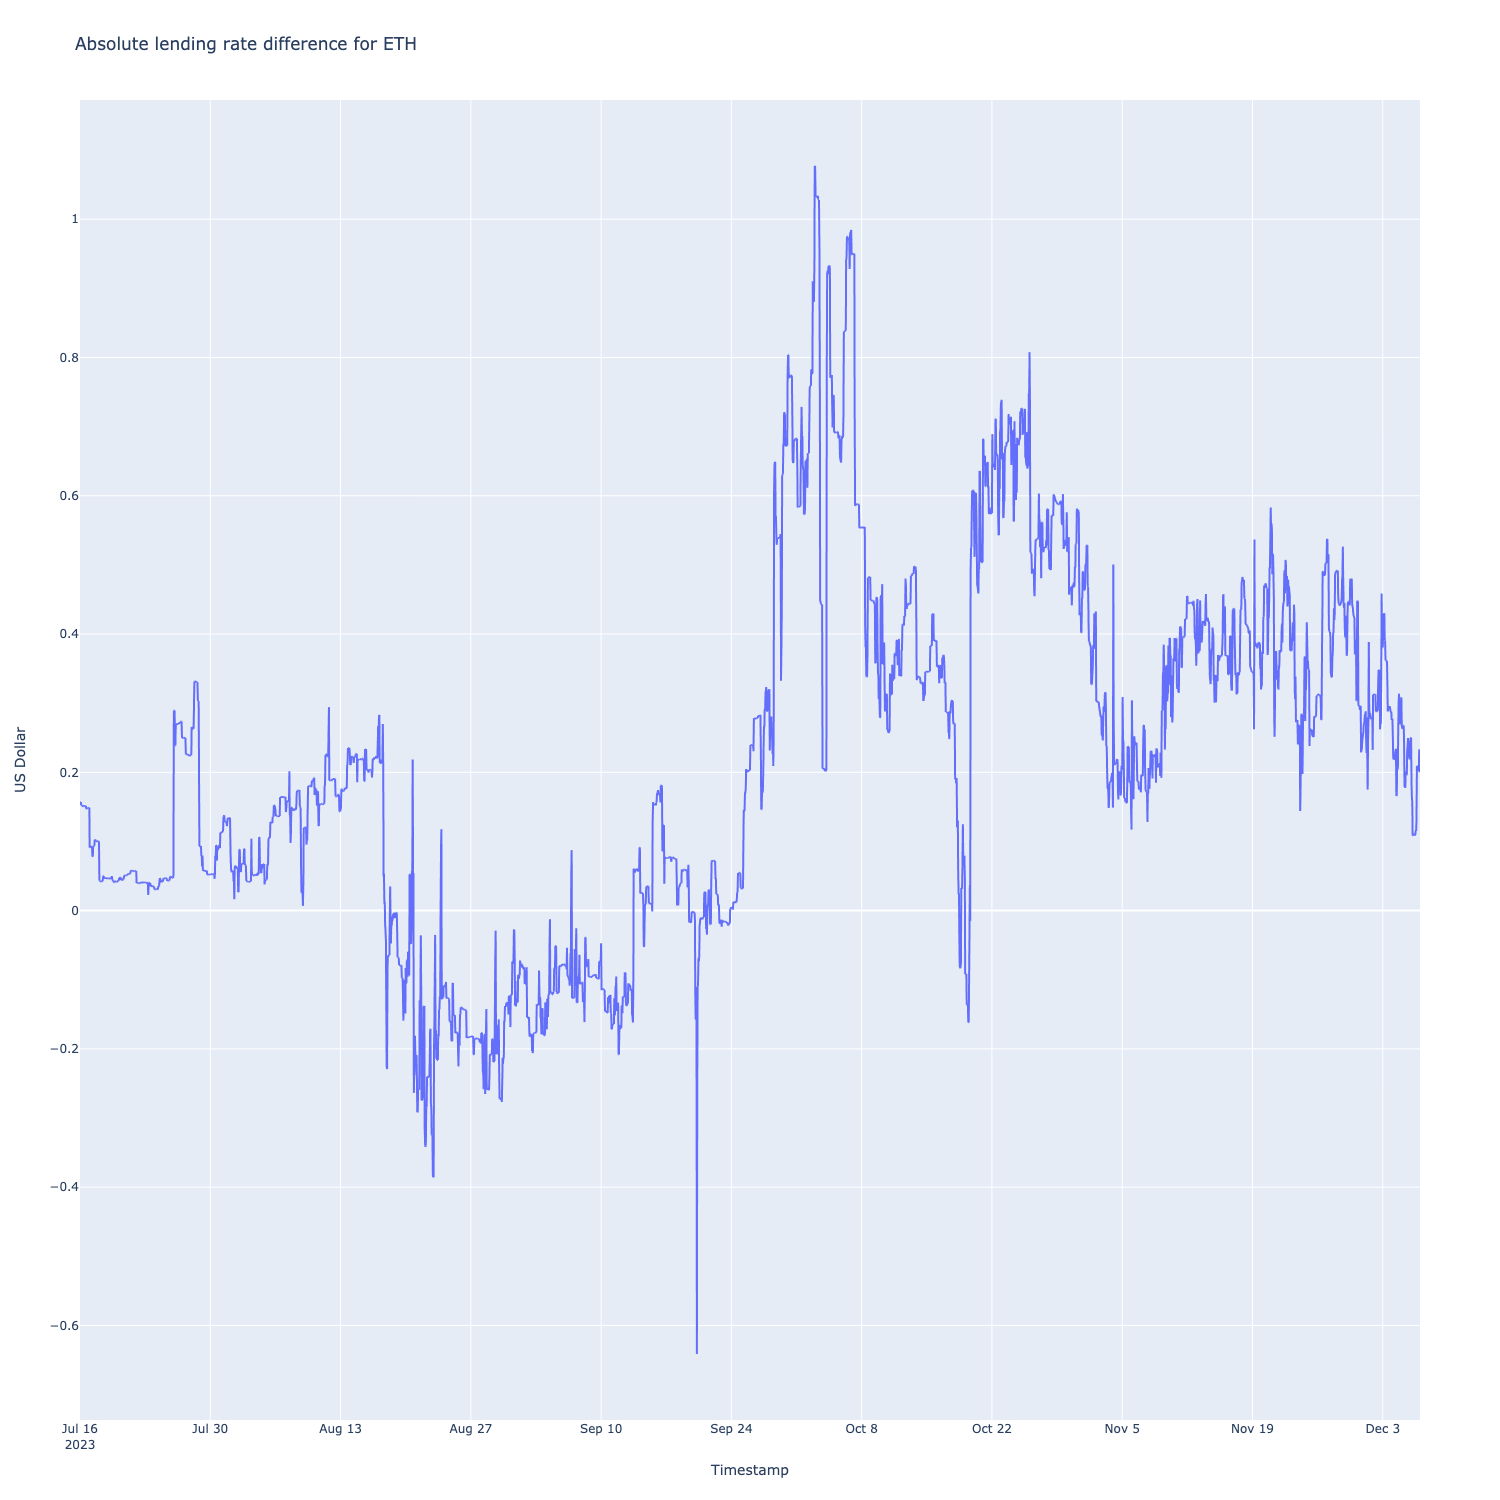

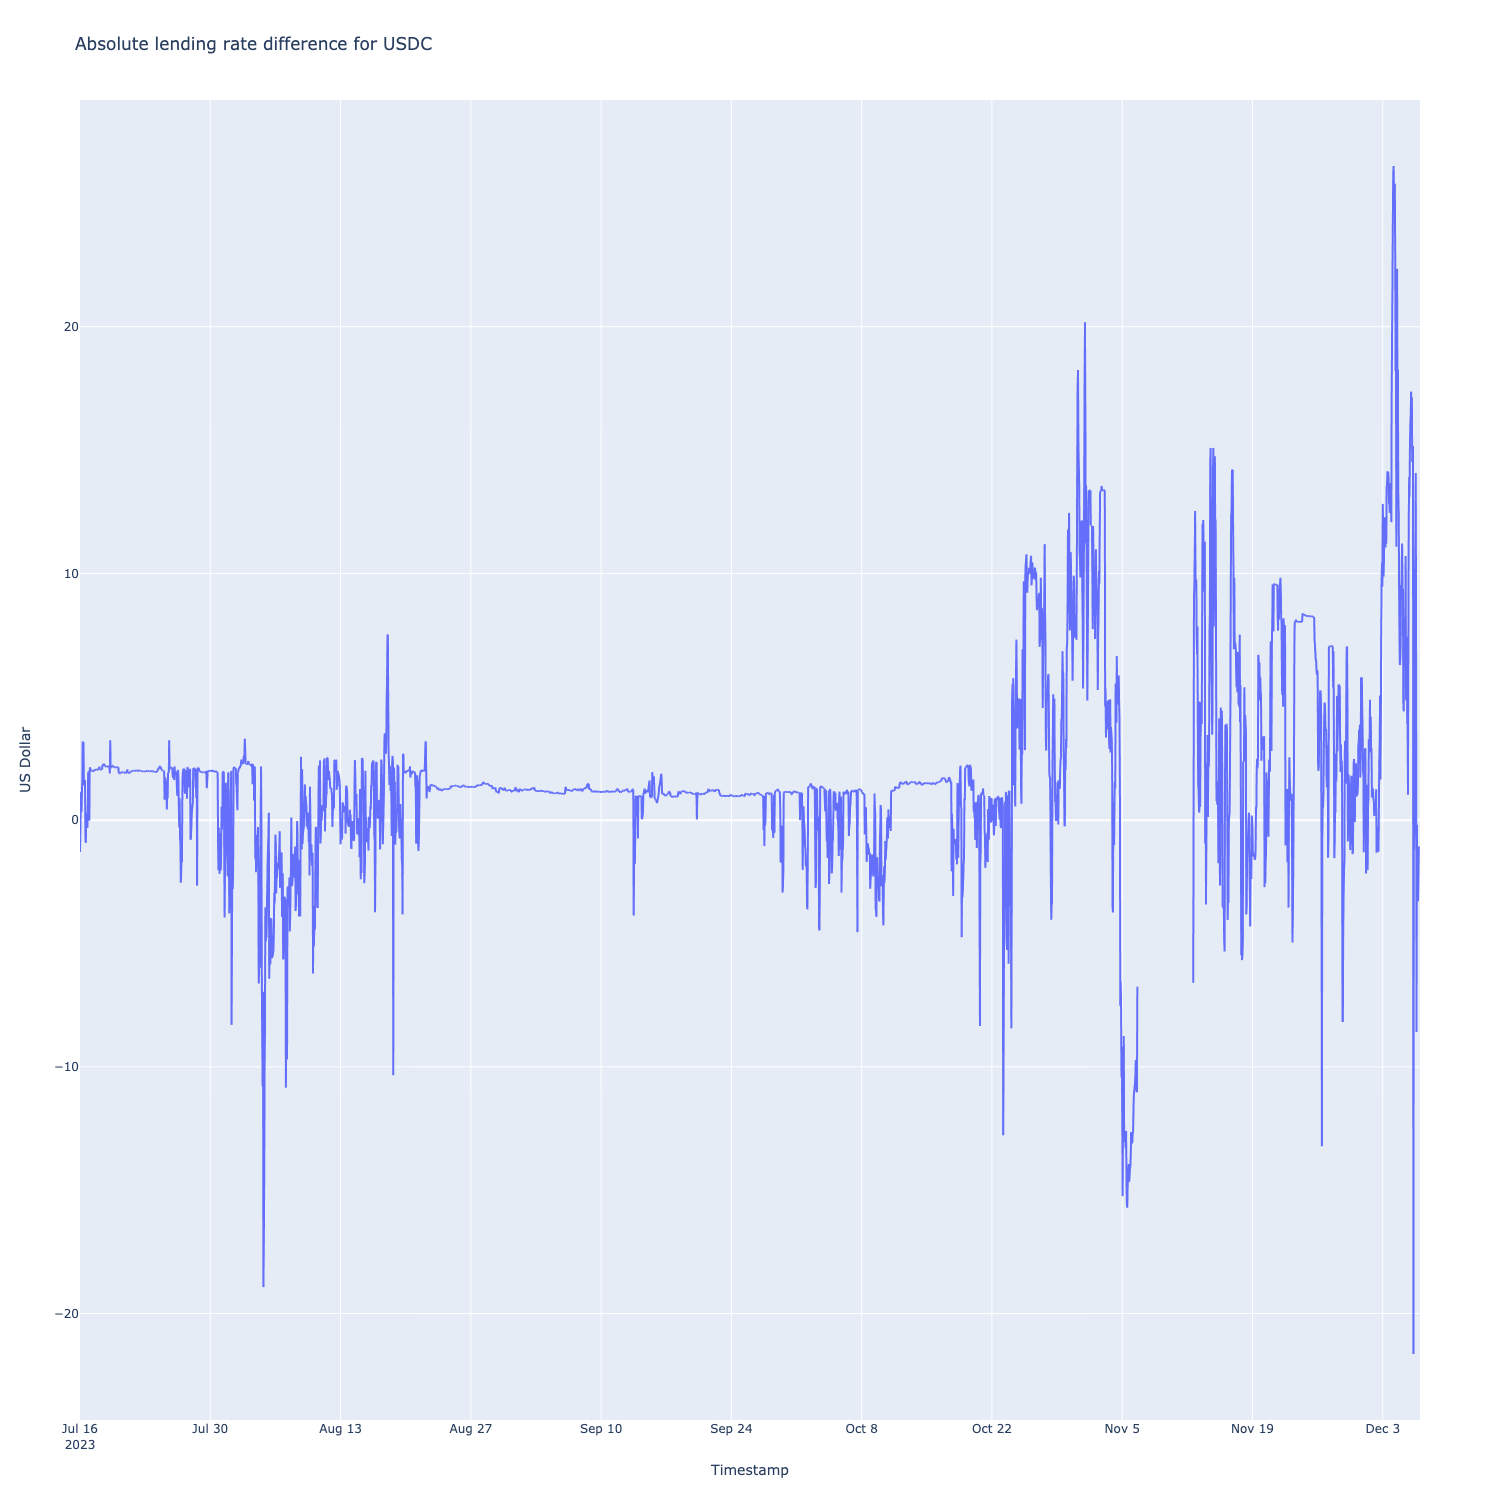

In [72]:
fig_eth = px.line(
    close_diff_eth,
    y=close_diff_eth,
    x=close_diff_eth.index,    
    title="Absolute lending rate difference for ETH",
)

fig_eth.update_yaxes(title="US Dollar")
fig_eth.update_xaxes(title="Timestamp")
fig_eth.show()


fig_usdc = px.line(
    close_diff_usdc,
    y=close_diff_usdc,
    x=close_diff_usdc.index,    
    title="Absolute lending rate difference for USDC",
)

fig_usdc.update_yaxes(title="US Dollar")
fig_usdc.update_xaxes(title="Timestamp")
fig_usdc.show()

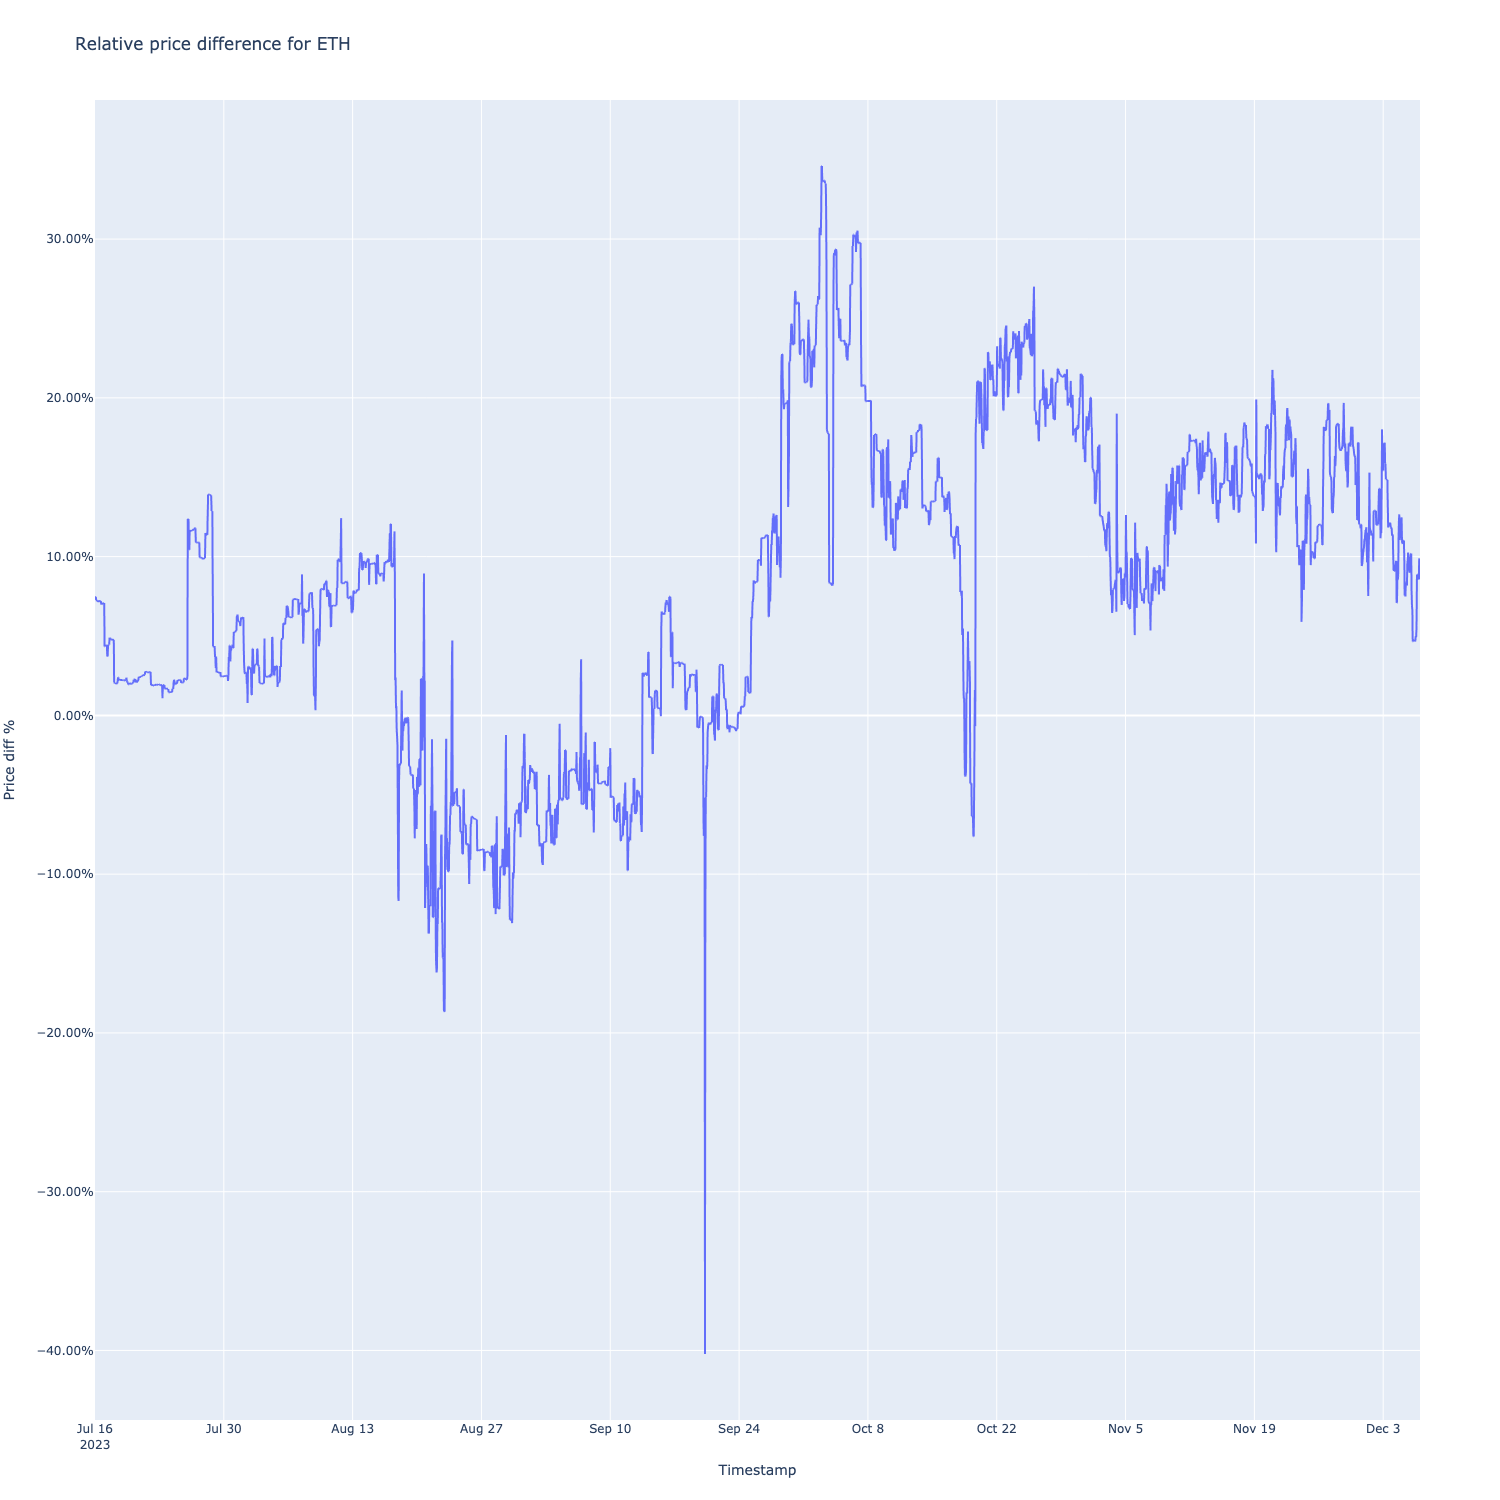

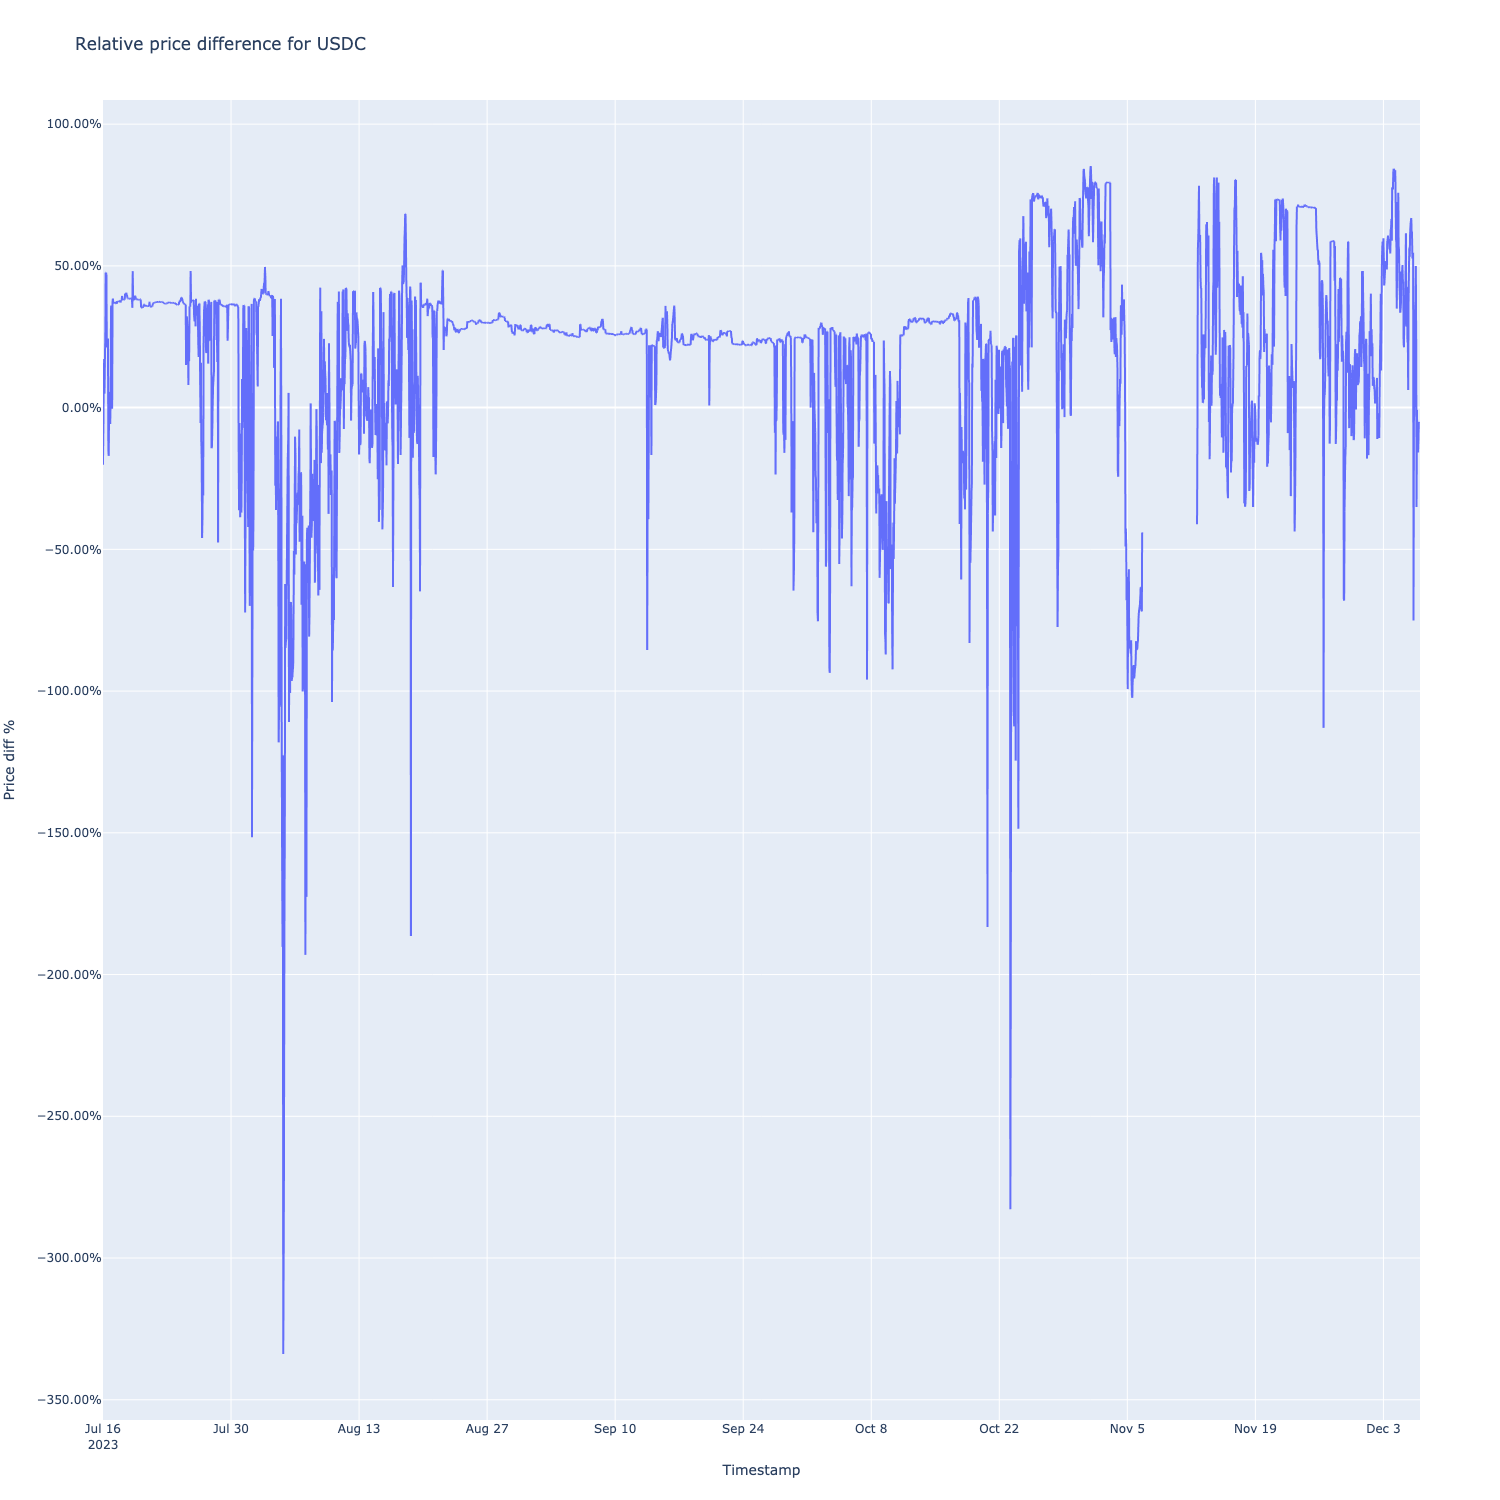

In [73]:
rel_diff_eth = close_diff_eth / binance_candles_eth["close"]

fig_eth = px.line(
    rel_diff_eth,
    y=rel_diff_eth,
    x=rel_diff_eth.index,
     title="Relative price difference for ETH",
)

fig_eth.layout.yaxis.tickformat = ',.2%'

fig_eth.update_yaxes(title="Price diff %")
fig_eth.update_xaxes(title="Timestamp")
fig_eth.show()

rel_diff_usdc = close_diff_usdc / binance_candles_usdc["close"]

fig_usdc = px.line(
    rel_diff_usdc,
    y=rel_diff_usdc,
    x=rel_diff_usdc.index,
     title="Relative price difference for USDC",
)

fig_usdc.layout.yaxis.tickformat = ',.2%'

fig_usdc.update_yaxes(title="Price diff %")
fig_usdc.update_xaxes(title="Timestamp")
fig_usdc.show()

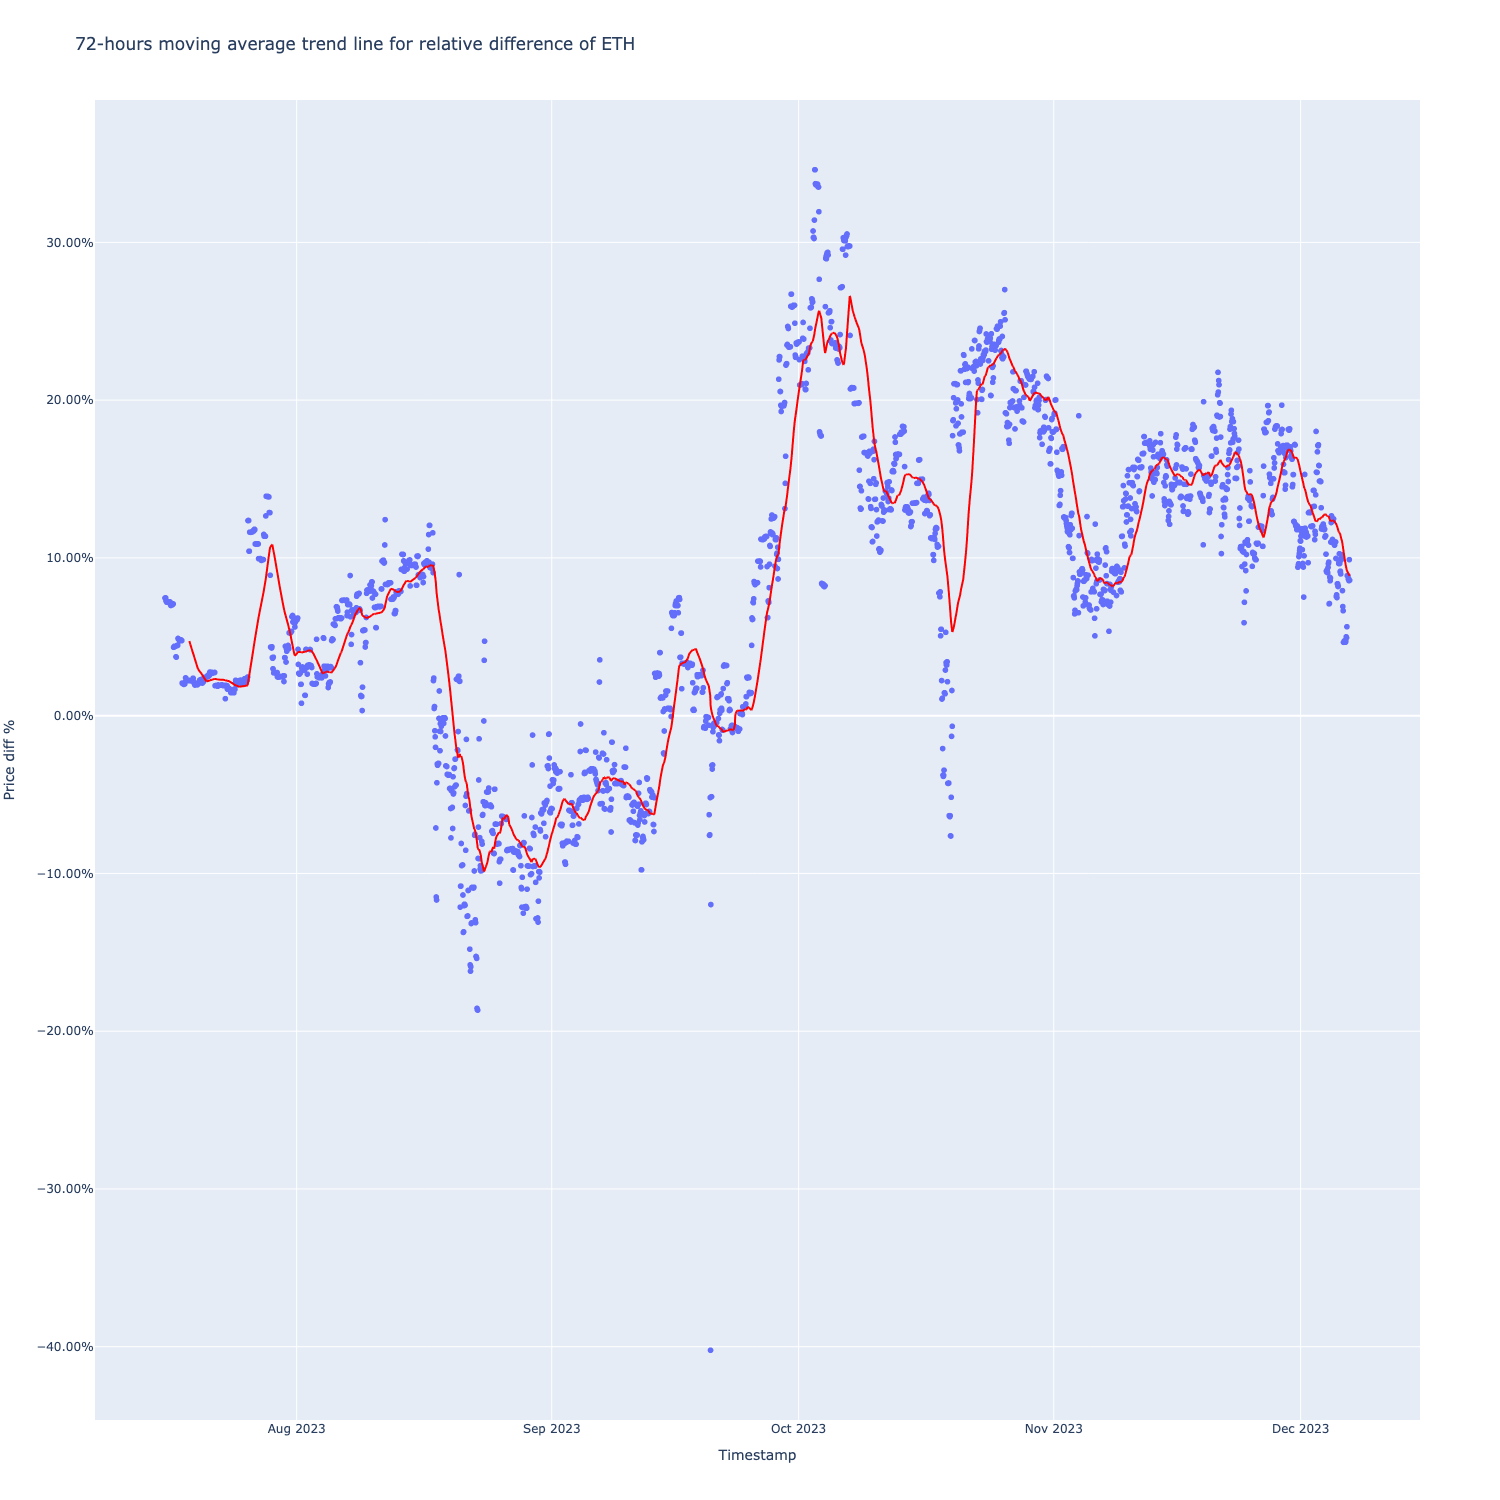

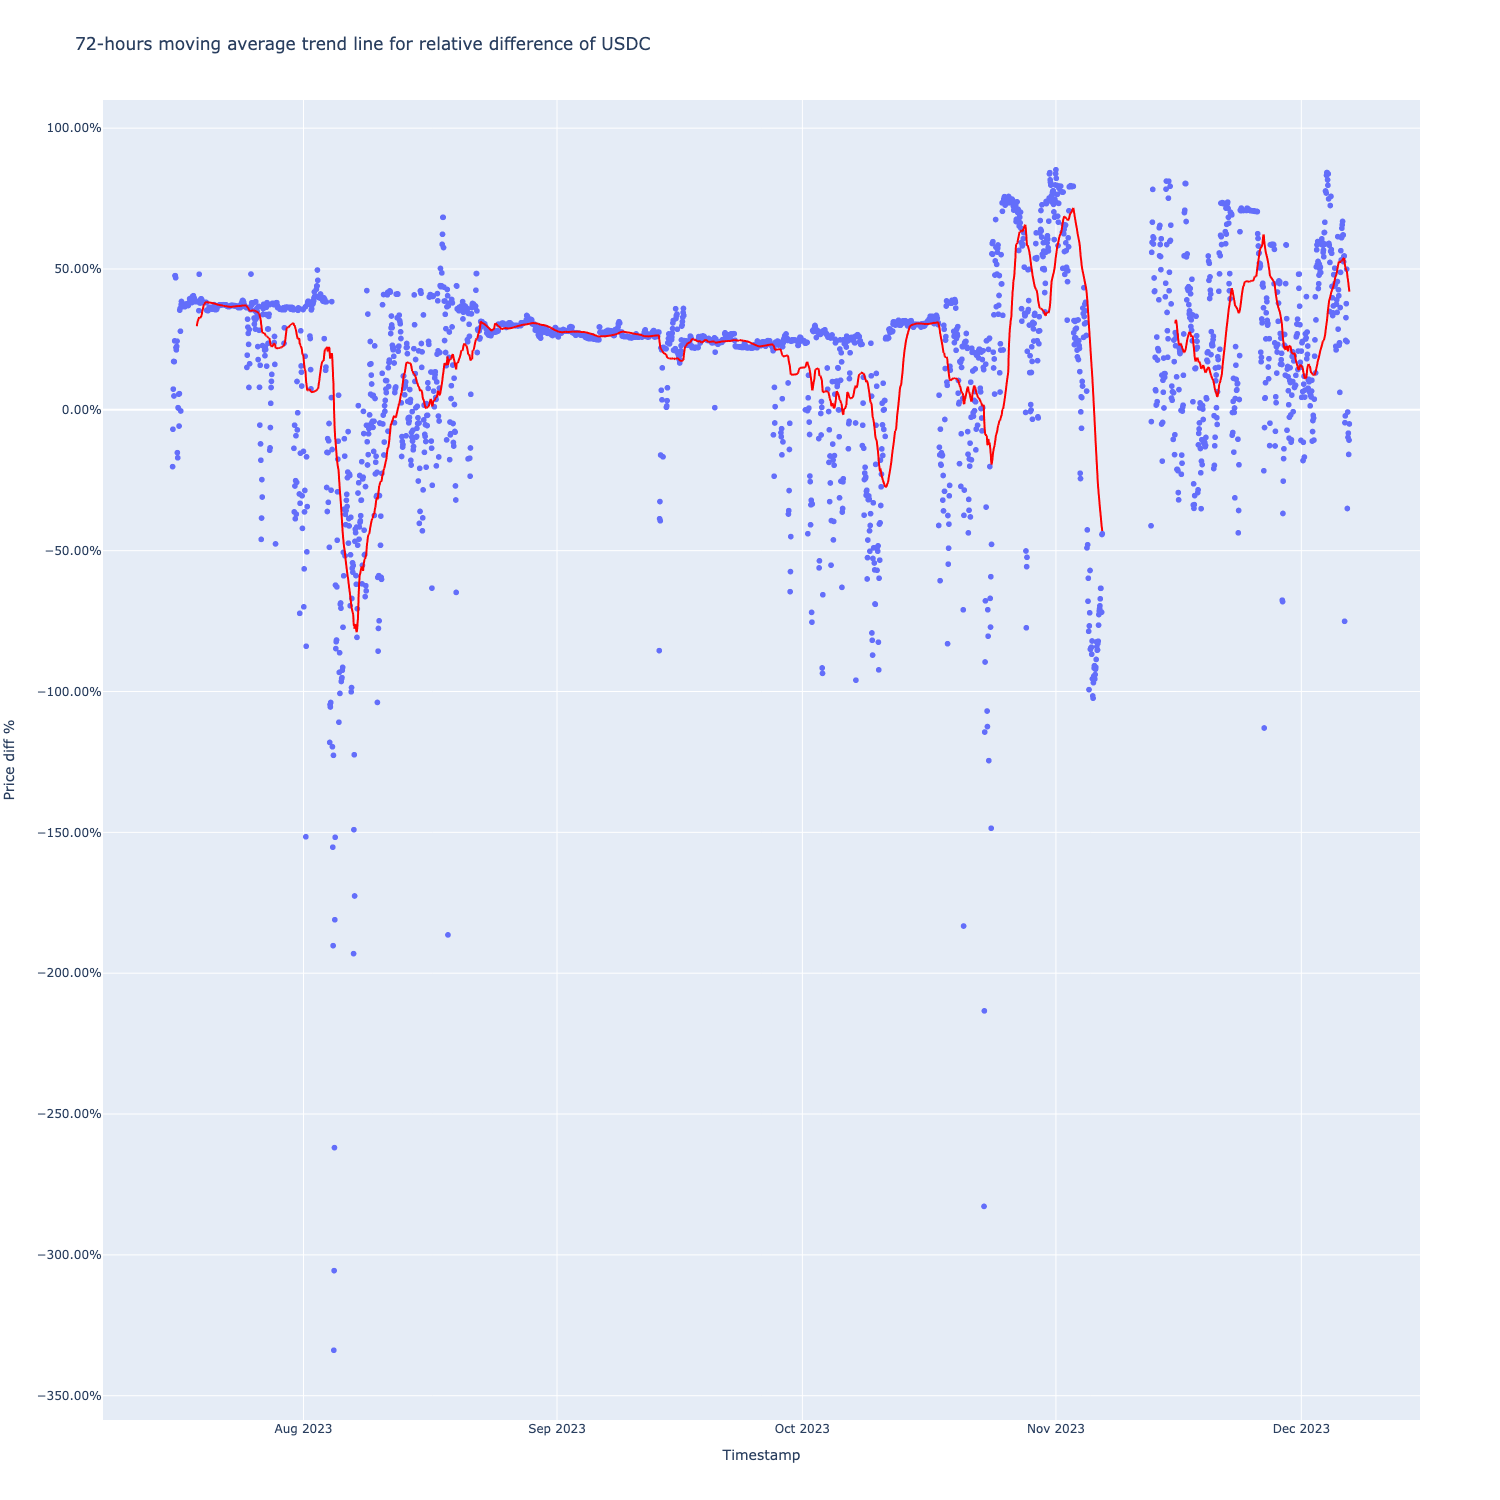

In [74]:
trend_period = 72

fig_eth = px.scatter(
    rel_diff_eth, 
    x=rel_diff_eth.index, 
    y=rel_diff_eth, 
    trendline="rolling", 
    trendline_options={"window": trend_period},
    title=f"{trend_period}-hours moving average trend line for relative difference of ETH")

# Set the trend line colour
# https://community.plotly.com/t/how-can-i-change-the-color-of-trendline/43432
fig_eth.data[1].update(line_color="red")

fig_eth.update_yaxes(title="Price diff %")
fig_eth.update_xaxes(title="Timestamp")
fig_eth.layout.yaxis.tickformat = ',.2%'

fig_eth.show()


fig_usdc = px.scatter(
    rel_diff_usdc, 
    x=rel_diff_usdc.index, 
    y=rel_diff_usdc, 
    trendline="rolling", 
    trendline_options={"window": trend_period},
    title=f"{trend_period}-hours moving average trend line for relative difference of USDC")

# Set the trend line colour
# https://community.plotly.com/t/how-can-i-change-the-color-of-trendline/43432
fig_usdc.data[1].update(line_color="red")

fig_usdc.update_yaxes(title="Price diff %")
fig_usdc.update_xaxes(title="Timestamp")
fig_usdc.layout.yaxis.tickformat = ',.2%'

fig_usdc.show()

# Analyse late trendline

Remove anomalies by looking only recent data.

- At the creation on WBTC-USDC pool it is likely there were fewer market markets present
- Look the charts above, and choose a time point where one belives market making become more established

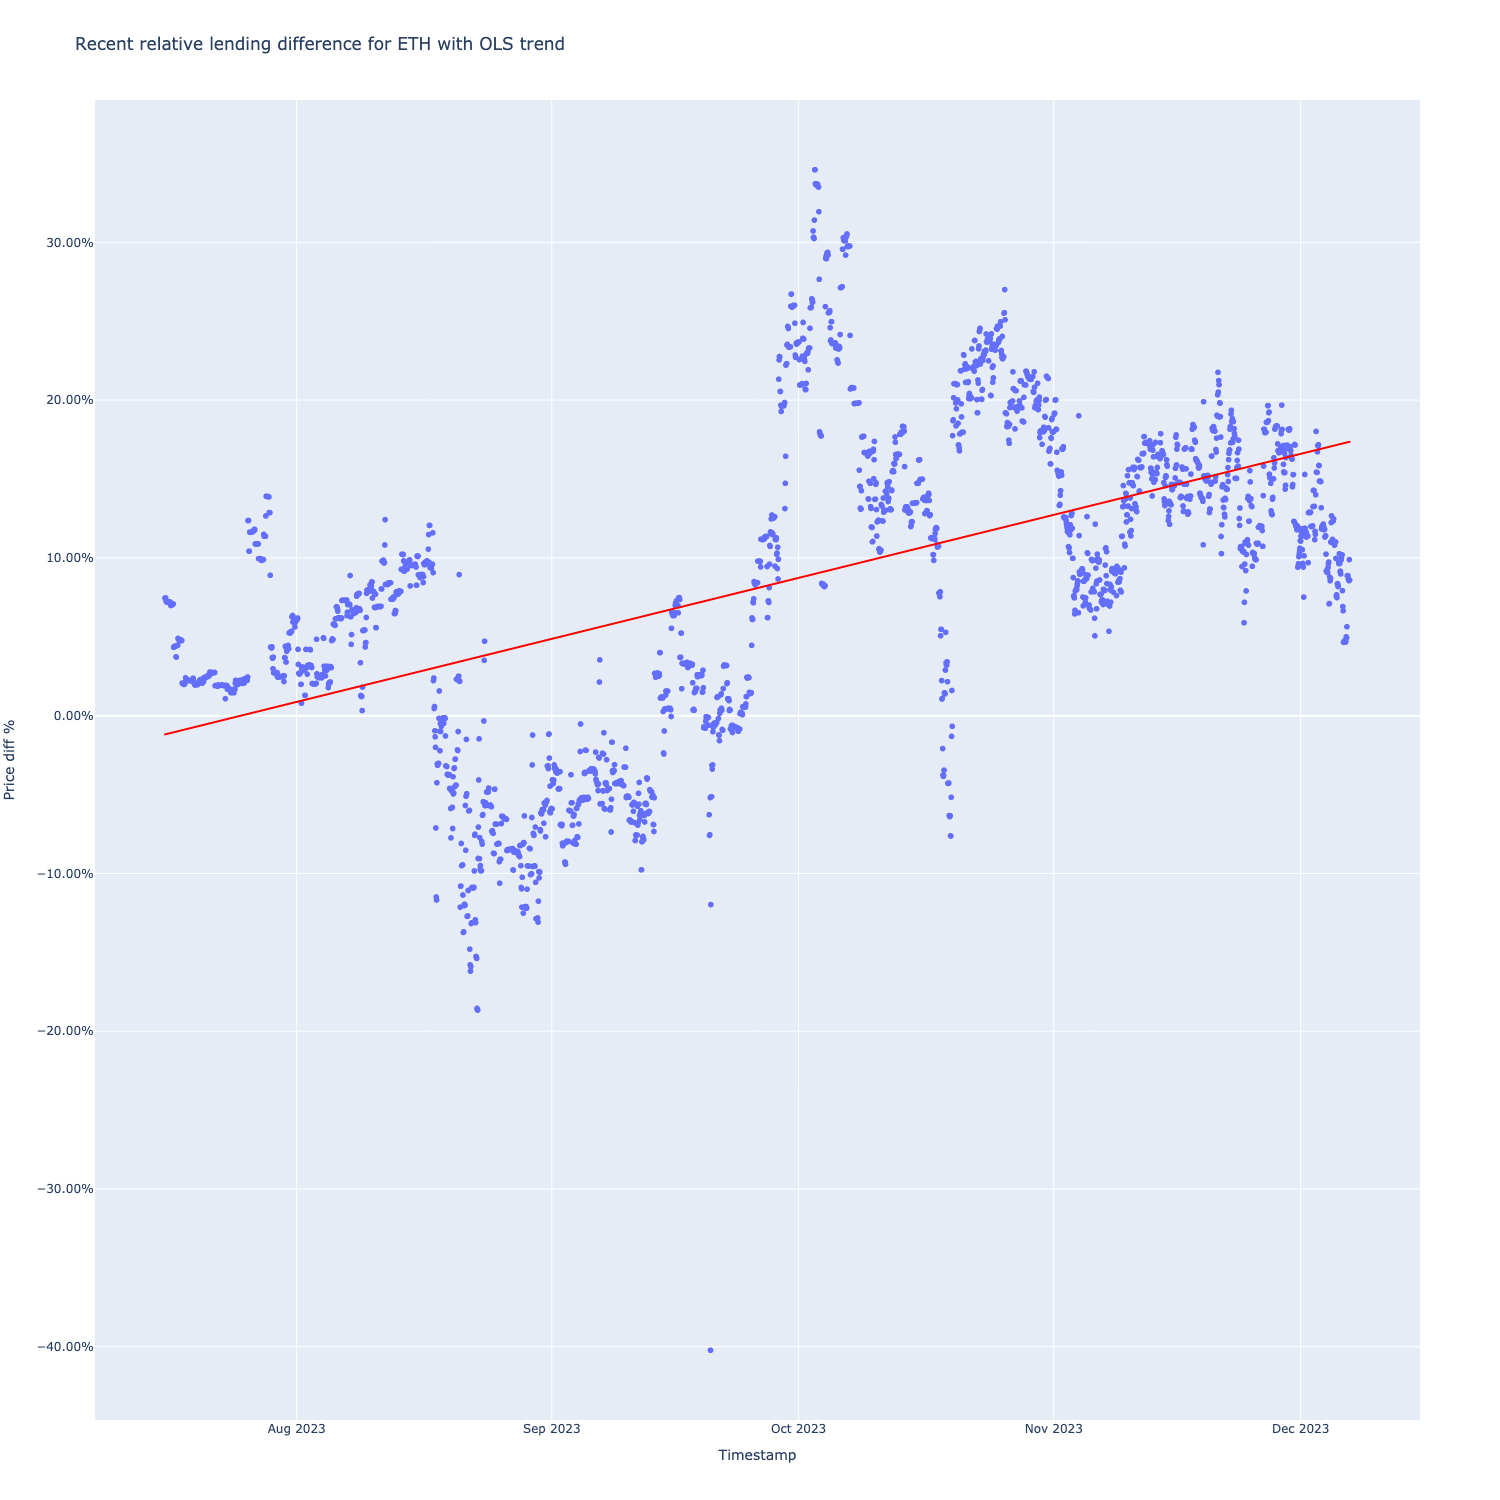

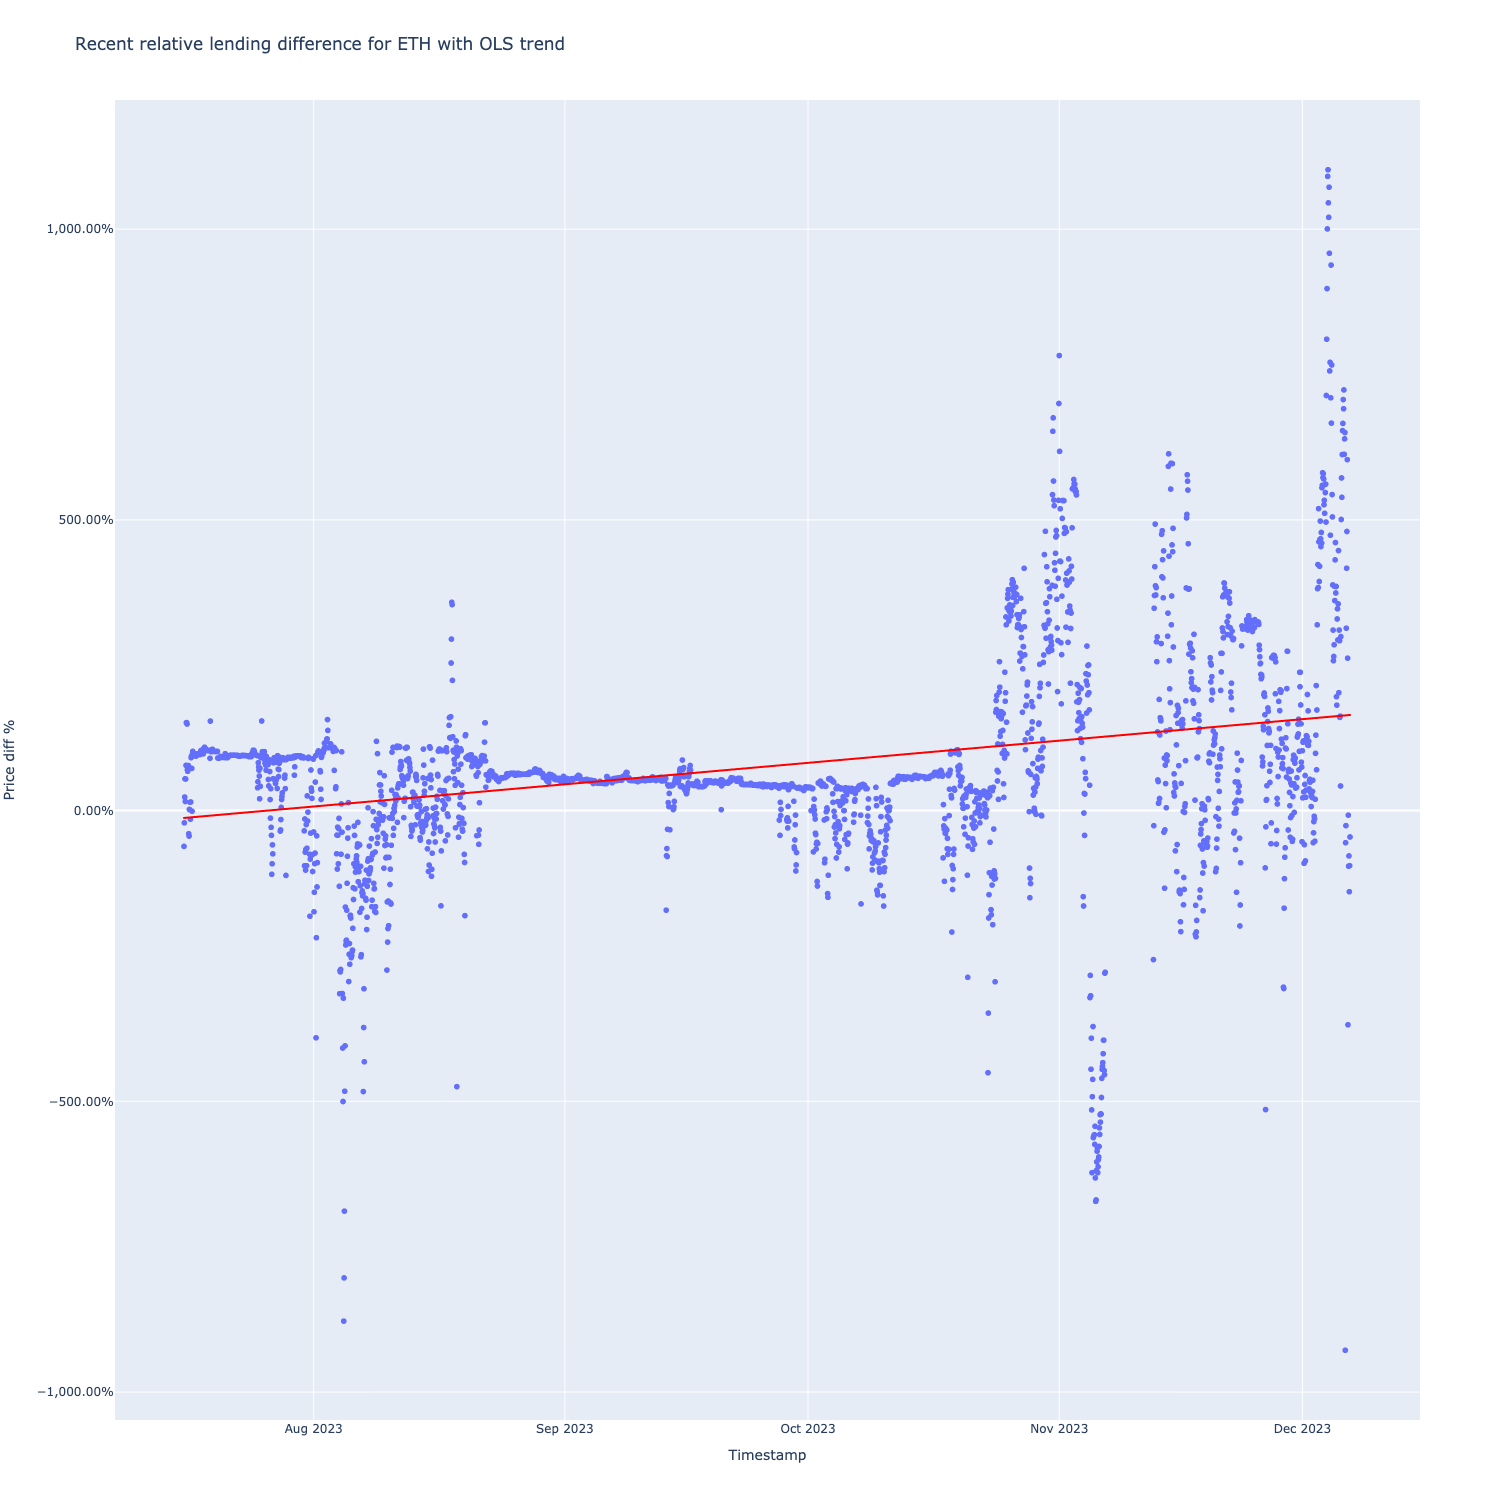

In [75]:
cut_off = pd.Timestamp("2023-04-01")

close_diff_eth = close_diff_eth[cut_off:]

rel_diff_eth = close_diff_eth / binance_candles_eth["close"]

fig_eth = px.scatter(
    rel_diff_eth,
    y=rel_diff_eth,
    x=rel_diff_eth.index,
    title="Recent relative lending difference for ETH with OLS trend",
    trendline="ols",
)

fig_eth.data[1].update(line_color="red")

fig_eth.update_yaxes(title="Price diff %")
fig_eth.update_xaxes(title="Timestamp")
fig_eth.layout.yaxis.tickformat = ',.2%'

fig_eth.show()


close_diff_usdc = close_diff_usdc[cut_off:]

rel_diff_usdc = close_diff_usdc / binance_candles_eth["close"]

fig_usdc = px.scatter(
    rel_diff_usdc,
    y=rel_diff_usdc,
    x=rel_diff_usdc.index,
    title="Recent relative lending difference for ETH with OLS trend",
    trendline="ols",
)

fig_usdc.data[1].update(line_color="red")

fig_usdc.update_yaxes(title="Price diff %")
fig_usdc.update_xaxes(title="Timestamp")
fig_usdc.layout.yaxis.tickformat = ',.2%'

fig_usdc.show()
